# Train a classifier with Mistral 7B

In this tutorial, we will see how we can leverage Mistral 7B to train a classifier. We need:
- The mistral codebase: `https://github.com/mistralai/mistral-src`
- The pretrained model and its tokenizer: `https://docs.mistral.ai/llm/mistral-v0.1`
- A dataset to train our classifier

We will train and evaluate the classifier on `Symptom2Disease`, a public classification dataset from Kaggle provided in a CSV format: https://www.kaggle.com/datasets/niyarrbarman/symptom2disease/

## Set paths

In [1]:
from pathlib import Path

code_path = "/codebase_path/mistral-src"  # codebase
data_path = Path("/dataset_path/Symptom2Disease.csv")  # dataset downloaded from Kaggle
model_path = Path("/model_path/")  # model and tokenizer location

## Imports

In [2]:
import csv
import tqdm
import torch
import numpy as np

import sys
sys.path.append(code_path)  # append the path where mistral-src was cloned

from mistral.model import Transformer
from mistral.tokenizer import Tokenizer

## Load the model and tokenizer

In [3]:
model = Transformer.from_folder(model_path, dtype=torch.bfloat16)
tokenizer = Tokenizer(str(model_path / "tokenizer.model"))

The tokenizer is a critical component of the model that segments input text into word-pieces.

For instance, the sentence `"Roasted barramundi fish"` is encoded as `['▁Ro', 'asted', '▁barr', 'am', 'und', 'i', '▁fish']`.

The number of subwords in the model is set to `32000`, and each word is decomposed into known word pieces to avoid unknown words.

## Load the dataset

We reload the Kaggle dataset from the disk. Each sample is composed of a sentence and a label. The dataset contains 24 different labels.

In [4]:
data = []  # list of (text, label)
with open(data_path, newline='') as csvfile:
    reader = csv.reader(csvfile)
    for i, row in enumerate(reader):
        if i == 0:  # skip csv header
            continue
        data.append((row[2], row[1]))

# label text to label ID
labels = sorted({x[1] for x in data})
txt_to_label = {x: i for i, x in enumerate(labels)}
print(f"Reloaded {len(data)} samples with {len(labels)} labels.")

# integer class for each datapoint
data_class = [txt_to_label[x[1]] for x in data]

Reloaded 1200 samples with 24 labels.


The task is to classify a symptom, for instance `"I have a dry cough that never stops."` to one of the 24 disease labels (`Acne, Arthritis, Bronchial Asthma, Cervical spondylosis, Chicken pox, Common Cold, etc.`).

## Embed data points in the dataset

We will now learn a linear classifier on frozen features provided by Mistral 7B.
In particular, each sentence in the dataset will be tokenized, and provided to the model.

If the input sentence is composed of `N` tokens, the model output will be a list of `N` vectors of dimension `d=4096`, where `d` is the dimensionality of the model.
These vectors are then averaged along the dimension 0 to get a vector of size `d`.

Finally, the vectors of all sentences in the dataset are concatenated into a matrix of shape `(D, d)` where `D` is the number of samples in the dataset (in particular, D=1200).

In [5]:
with torch.no_grad():
    featurized_x = []
    # compute an embedding for each sentence
    for i, (x, y) in tqdm.tqdm(enumerate(data)):
        tokens = tokenizer.encode(x, bos=True)
        tensor = torch.tensor(tokens).to(model.device)
        features = model.forward_partial(tensor, [len(tokens)])  # (n_tokens, model_dim)
        featurized_x.append(features.float().mean(0).cpu().detach().numpy())

# concatenate sentence embeddings
X = np.concatenate([x[None] for x in featurized_x], axis=0)  # (n_points, model_dim)

1200it [00:25, 46.65it/s]


## Plot t-SNE embeddings

Now that we have one vector/embedding for each sample in our dataset, we can visualize them using t-SNE.
t-SNE is a powerful tool for reducing the dimensionality of high-dimensional data, while preserving the underlying structure and relationships between the data points, which can help uncover patterns and insights that would be difficult to discern in the high-dimensional space.

In the graph below, we assign a different color to each class in the dataset. It is apparent that several distinct clusters are visible in the data.

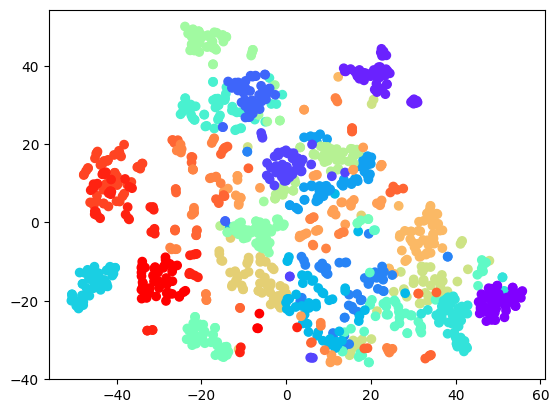

In [6]:
import sklearn
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from matplotlib.cm import rainbow

# This is a sanity check that our data clusters nicely
# map our feature space to 2D, plot it and color it by its labels

reduced = sklearn.manifold.TSNE(n_components=2, random_state=0).fit_transform(X)
plt.scatter(reduced[:, 0], reduced[:, 1], c=data_class, cmap='rainbow')
plt.show()

## Create a train / test split

For the sake of demonstration, we will shuffle the dataset and split it into two train and test splits composed of 80% and 20% of the data.

In [7]:
# make things reproducible
rng = np.random.default_rng(seed=0)

# shuffle the data
permuted = rng.permutation(len(X))
shuffled_x, shuffled_class = X[permuted], np.array(data_class)[permuted]

# create a train / test split
train_prop = 0.8
n_train = int(len(shuffled_x) * 0.8)
train_x, train_y = shuffled_x[:n_train], shuffled_class[:n_train]
test_x, test_y = shuffled_x[n_train:], shuffled_class[n_train:]

# summary
print(f"Train set : {len(train_x)} samples")
print(f"Test set  : {len(test_x)} samples")

Train set : 960 samples
Test set  : 240 samples


## Normalize features

It is usually recommended to normalize features to improve the performance and stability of the classifier.
In particular, we ensure that each feature in the training set has a mean of 0 and a standard deviation of 1.
This can be done with [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) of Scikit-learn:

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x)

## Train a classifier and compute the test accuracy

We can now train the classifier. We will use the [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) object of Scikit-learn.

The default learning alborithm is `lbfgs`, which should give an accuracy of 98.33% for this particular train/test split.

You can try different algorithms, and hyper-parameters. In a real-life scenario, it is possible to obtain better results by using k-fold cross-validation methods to validate accuracy and choice of the hyperparameters.

In [9]:
from sklearn.linear_model import LogisticRegression

# For a real problem, C should be properly cross validated and the confusion matrix analyzed
clf = LogisticRegression(random_state=0, C=1.0, max_iter=500).fit(train_x, train_y)  # 98.33%

# you can also try the sag algorithm:
# clf = LogisticRegression(random_state=0, C=1.0, max_iter=1000, solver='sag').fit(train_x, train_y)

print(f"Precision: {100*np.mean(clf.predict(test_x) == test_y):.2f}%")

Precision: 98.33%


## Classify a single example

Below is an example showing how to classify new samples, and how to print the probabilities of the top-5 predicted labels.

In [10]:
@torch.no_grad()
def classify(s: str):
    tokens = tokenizer.encode(s, bos=True)
    tensor = torch.tensor(tokens).to(model.device)
    features = model.forward_partial(tensor, [len(tokens)])  # (n_tokens, model_dim)
    embedding = features.float().mean(0).cpu().detach().numpy()
    probas = clf.predict_proba(embedding[None])
    assert probas.shape == (1, len(labels))
    return probas[0]

In [11]:
sentence = "I have been feeling excessively hungry, even after eating, and have had a stiff neck."
probas = classify(sentence)

for i in np.argsort(probas)[::-1][:5]:
    print(f"{100*probas[i]:6.2f}%  {labels[i]}")

 99.65%  Migraine
  0.20%  Dengue
  0.08%  Cervical spondylosis
  0.05%  Jaundice
  0.02%  allergy


## Second implementation: Zero shot

Below is another method to do classification which does not require any training set.
It also does not require to train a classifier on top of Mistral.
However, it is much slower to predict, and it is not expected to work as well as the previous method in the case where you have a training dataset available.

The method consists in prompting the model with the following text:

```
Symptoms: {symptom}
Disease:
```

and to evaluate the probability that the model predicts each of the possible labels.
The method is quite slower, because you need to compute the probability of all labels.

In [12]:
model.args.max_batch_size = len(labels)

test_data = [data[i] for i in permuted[n_train:]]

good = []

with torch.no_grad():

    for i, (symptom, disease) in tqdm.tqdm(enumerate(test_data)):
    
        # given an input, predict the probability of each output (one output corresponds to one label)
        input_ids, seq_lengths, output_lengths = [], [], []
        for label in labels:
            prefix = f"Symptoms: {symptom}\nDisease:"
            tokens = tokenizer.encode(f"{prefix} {label}", bos=True)
            input_ids.extend(tokens)
            seq_lengths.append(len(tokens))
            output_lengths.append(len(tokens) - len(tokenizer.encode(prefix, bos=True)))
        tensor = torch.tensor(input_ids).to(model.device)
        logprobs = torch.log_softmax(model.forward(tensor, seq_lengths), dim=-1)  # sum_slens * vocab_size
        
        # select logprobs for each output
        offset = 0
        avg_logprobs = []
        for slen, output_len in zip(seq_lengths, output_lengths):
            output_tokens = input_ids[offset + slen - output_len:offset + slen]
            output_logprobs = torch.gather(
                logprobs[offset + slen - output_len - 1:offset + slen - 1],
                dim=1,
                index=torch.tensor(output_tokens).to(model.device)[:, None],
            ).mean().item()
            avg_logprobs.append(output_logprobs)
            offset += slen

        good.append(np.argmax(avg_logprobs) == txt_to_label[disease])
    
print(f"Accuracy: {100 * np.mean(good):.2f}%")

240it [00:14, 16.82it/s]

Accuracy: 30.42%


Even though this approach did not require any training set, the performance is only of 30.4%, compared to 98.3% for the previous, faster one.